[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/okada-tak/deep-learning-from-scratch-2/blob/master/notebooks/ch01.ipynb)

# 1章 ニューラルネットワークの復習 のまとめ
- ニューラルネットワークは、入力層、隠れ層、出力層を持つ
- 全結合層によって線形な変換が行われ、活性化関数によって非線形な変換が行われる
- 全結合層やミニバッチ処理は、行列としてまとめて計算することができる
- 誤差逆伝播法を使って、効率的にニューラルネットワークの損失に関する勾配を求めることができる
- ニューラルネットワークで行う処理は、計算グラフによって可視化することができ、順伝播や逆伝播の理解に役立つ
- ニューラルネットワークの実装では、構成要素を「レイヤ」としてモジュール化することで、組み立てが容易になる
- ニューラルネットワークの高速化において、データのビット精度とGPUによる並列計算が重要である

## 4.2.1 2乗和誤差
$$
E=\frac{1}{2}\sum_k (y_k-t_k)^2
$$
$y_k$ : ニューラルネットワークの出力  
$t_k$ : 教師データ  
$k$ : データの次元数

In [ ]:
# p.89
def sum_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [ ]:
# p.89
# 「2」を正解とする
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
import numpy as np
# p.89
# 例1: 「2」の確率が最も高い場合 (0.6)
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
sum_squared_error(np.array(y), np.array(t))

0.09750000000000003

In [ ]:
# ■岡田追記
# yは確率なので合計すると1になる（ような数値を例にしている）ことを確認。
np.sum(y)

1.0

In [ ]:
# p.89
# 例2: 「7」の確率が最も高い場合 (0.6)。「2」の確率は0.1。
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
sum_squared_error(np.array(y), np.array(t))

0.5975

## 4.2.2 交差エントロピー誤差
$$
E=-\sum_k t_k \log{y_k}
$$
$\log$ : 底が$e$の自然対数（$\log_e$)  
$y_k$ : ニューラルネットワークの出力  
$t_k$ : 正解ラベル（正解ラベルとなるインデックスだけが1で、その他は0（one-hot表現））  
$k$ : データの次元数（ただし正解ラベル以外は0となるので正解ラベルのみ計算すればよい）

$y=-\log(x)$において、$x$が1に近づくほど$y$が0に近づく。（確率が1に近づくほど誤差が0に近づく。）  
p.90の図4.3よりこちらのほうがわかりやすいかと思う。

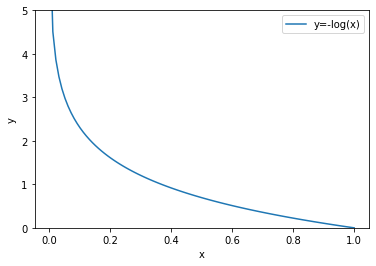

In [ ]:
# 岡田追記。p.90図4-3の変形。
import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.001, 1.01, 0.01)
y = -np.log(x)
plt.plot(x, y, label='y=-log(x)')
plt.ylim(0.0, 5.0)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
# p.91
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [ ]:
# p.91
# 「2」を正解とする
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# p.91
# 例1: 「2」の確率が最も高い場合 (0.6)
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [ ]:
# p.91
# 例2: 「7」の確率が最も高い場合 (0.6)。「2」の確率は0.1。
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

## 4.2.3 ミニバッチ学習

# ■追記（岡田）Colaboratory用
Google Colaboratoryの場合、Google Driveに  
dl-from-scratch/ch04  
というフォルダを用意し、そこにこのjupyter notebookを配置。  
(dl-from-scratchの部分は任意。)  
また、datasetフォルダとcommonフォルダを
dl-from-scratch/dataset  
dl-from-scratch/common
にコピーしておく。  

以下のセルでGoogle Driveをマウント。許可を求められるので許可する。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ■追記（岡田）Colaboratory用
chdirする。

In [ ]:
import sys,os
os.chdir('/content/drive/My Drive/dl-from-scratch/')
os.getcwd()

'/content/drive/My Drive/dl-from-scratch'

In [ ]:
# MNISTデータセットの読み込み
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [ ]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [ ]:
np.random.choice(60000, 10)
# 実行するたびに違う結果が返る

array([ 1745, 20016, 54247, 20399,   650, 20073, 22179, 13816,  5033,
       43750])

In [ ]:
print(x_batch)
print(t_batch)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [ ]:
print(x_batch.shape)
print(t_batch.shape)
print(x_batch.shape[0])

(10, 784)
(10, 10)
10


## 4.2.4 [バッチ対応版] 交差エントロピー誤差の実装

In [ ]:
# p.94
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [ ]:
cross_entropy_error(np.array(y), np.array(t))
# p.91と同じ結果になる。

2.302584092994546

## 4.3.1 微分

In [ ]:
# p.99
# 中心差分で計算している
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

# ch04/gradient_1d.py

0.1999999999990898


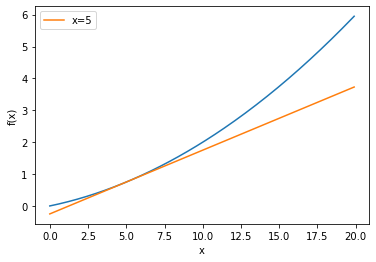

In [ ]:
import numpy as np
import matplotlib.pylab as plt


def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)


def function_1(x):
    return 0.01*x**2 + 0.1*x 


def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2, label='x=5') # label追加（岡田）
plt.legend() # 凡例表示
plt.show()

0.2999999999986347


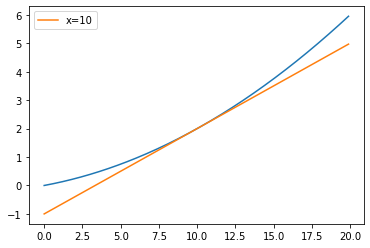

In [ ]:
# x=10についても追加
tf2 = tangent_line(function_1, 10)
y3 = tf2(x)

plt.plot(x, y)
plt.plot(x, y3, label='x=10')
plt.legend()
plt.show()

## 4.3.3 偏微分

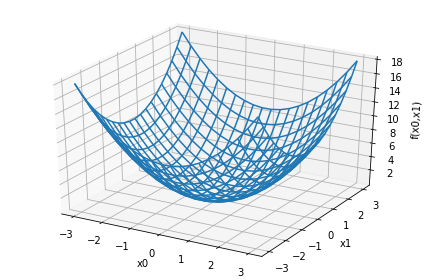

In [ ]:
# p.102のグラフを描く
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("f(x0,x1)")

# p.102の関数
def function_2(x):
    return x[0]**2 + x[1]**2

data = np.linspace(-3,3,20)
x, y = np.meshgrid(data,data)
x1 = np.stack([x,y])

# zデータの作成
# z = x**2 + y**2　でもいい
z = function_2(x1)

ax.plot_wireframe(x,y,z)

# 軸ラベルが見切れたので追加
plt.tight_layout()

plt.show()

$f(x_0, x_1) = x_0^2 + x_1^2$  
  
$\frac{\partial f}{\partial x0} = 2x_0$  

$\frac{\partial f}{\partial x1} = 2x_1$

In [ ]:
# p.103
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

In [ ]:
numerical_diff(function_tmp1, 3.0)

6.00000000000378

In [ ]:
# p.103
def function_tmp2(x1):
    return 3.0**2.0 + x1*x1

In [ ]:
numerical_diff(function_tmp2, 4.0)

7.999999999999119

# ch04/gradient_2d.py

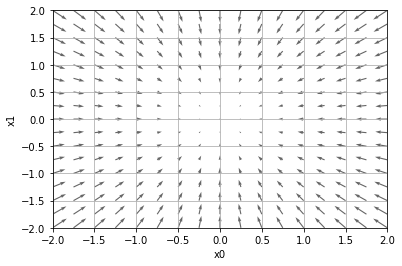

In [ ]:
# cf.http://d.hatena.ne.jp/white_wheels/20100327/p3
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D


def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 値を元に戻す
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y


if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()

    grad = numerical_gradient(function_2, np.array([X, Y]).T).T

    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
    # quiver(X, Y, U, V, [C])
    # X, Yはベクトルの開始点、U, Vはベクトルの成分、Cはベクトルの大きさに応じたカラーマップ上の色をつけるための配列。
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.draw()
    plt.show()

In [ ]:
# p.104下の実行例 3つ
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [ ]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [ ]:
numerical_gradient(function_2, np.array([3.0, 0.0]))

array([6., 0.])

## 4.4.1 勾配法

$x_0 = x_0 - \eta \frac{\partial f}{\partial x0}$  

$x_1 = x_1 - \eta \frac{\partial f}{\partial x1}$ 

$\eta$は学習率。（ハイパーパラメータ）

# ch04/gradient_method.py

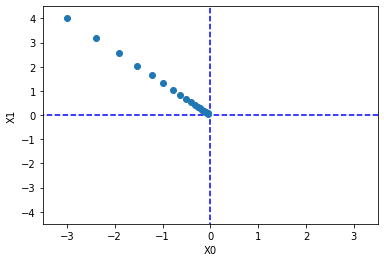

In [ ]:
import numpy as np
import matplotlib.pylab as plt


def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

In [ ]:
# p.108
# 学習率が大きすぎる例：lr=10.0
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100)

(array([-2.58983747e+13, -1.29524862e+12]),
 array([[-3.00000000e+00,  4.00000000e+00],
        [ 5.70000000e+01, -7.60000000e+01],
        [-1.08300000e+03,  1.44400000e+03],
        [ 2.05770000e+04, -2.74360000e+04],
        [-3.90963008e+05,  5.21284002e+05],
        [ 7.42829664e+06, -9.90439654e+06],
        [-1.41137328e+08,  1.88183103e+08],
        [ 2.68126267e+09, -3.57501690e+09],
        [-5.09763373e+10,  6.79001831e+10],
        [ 9.45170863e+11, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.295

In [ ]:
# p.109 学習率が小さすぎる例：lr=1e-10
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100)

(array([-2.99999994,  3.99999992]), array([[-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  3.99999999],
        [-3.        ,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999998,  3.99999998],
        [-2.99999998,  3.9999

# ch04/gradient_simplenet.py

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient


class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

print(dW)

[[ 0.16265122  0.0129395  -0.17559072]
 [ 0.24397683  0.01940925 -0.26338609]]


In [ ]:
# p.111
net = simpleNet()
print(net.W)

[[-1.3675511   0.25952139  1.2106133 ]
 [-1.57966259 -0.44882087 -0.77993764]]


In [ ]:
# p.111
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-2.24222699 -0.24822595  0.0244241 ]


In [ ]:
# p.111
np.argmax(p)

2

In [ ]:
# p.111
# np.random使っているので正解の位置が変わるかもしれない。↑で出た個所が1になるようにする。
t = np.array([0, 0, 1])
net.loss(x, t)

0.6232704751084841

In [ ]:
# p.111
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.03334833  0.24493889 -0.27828722]
 [ 0.0500225   0.36740834 -0.41743083]]


## 確率的勾配降下法 (stochastic gradient descent: SGD)  

ステップ１（ミニバッチ）  
    　訓練データの中からランダムに一部のデータ（ミニバッチ）を選び出す。

ステップ２（勾配の算出）  
    　ミニバッチの損失関数を減らすために、各重みパラメータの勾配を求める。

ステップ３（パラメータの更新）  
    　重みパラメータを勾配方向に微少量だけ更新する。

ステップ４（繰り返す）  
    　↑を繰り返す。


# ch04/two_layer_net.py

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from common.functions import *
from common.gradient import numerical_gradient
import numpy as np


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

## 4.5.2 ミニバッチ学習の実装

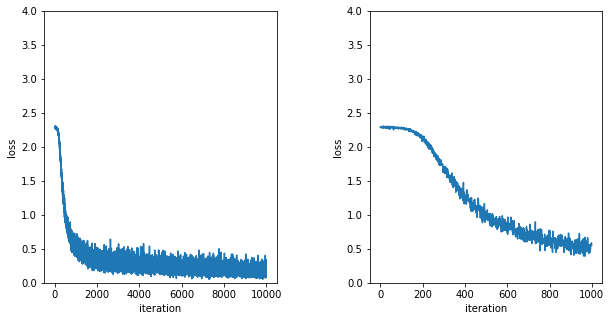

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
# グラフの描画
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
plt.subplots_adjust(wspace=0.4)

ax1.plot(train_loss_list[0:10000])
ax1.set_xlabel("iteration")
ax1.set_ylabel("loss")
ax1.set_ylim(0, 4.0)

ax2.plot(train_loss_list[0:1000])
ax2.set_xlabel("iteration")
ax2.set_ylabel("loss")
ax2.set_ylim(0, 4.0)

plt.show()

# ch04/train_neuralnet.py

## テキストでは学習率lr=0.1となっている

train acc, test acc | 0.10218333333333333, 0.101
train acc, test acc | 0.7827333333333333, 0.7857
train acc, test acc | 0.87775, 0.8828
train acc, test acc | 0.8982666666666667, 0.9014
train acc, test acc | 0.9070666666666667, 0.9094
train acc, test acc | 0.9130833333333334, 0.9166
train acc, test acc | 0.91865, 0.9217
train acc, test acc | 0.9225166666666667, 0.9256
train acc, test acc | 0.9262333333333334, 0.9272
train acc, test acc | 0.9296333333333333, 0.9308
train acc, test acc | 0.9323833333333333, 0.9335
train acc, test acc | 0.9352833333333334, 0.9359
train acc, test acc | 0.937, 0.9363
train acc, test acc | 0.9402666666666667, 0.9386
train acc, test acc | 0.9413333333333334, 0.9403
train acc, test acc | 0.9439666666666666, 0.9412
train acc, test acc | 0.9456, 0.9426


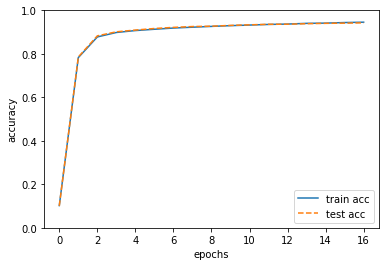

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

↑はきれいに収束しているようにみえる。

# では学習率を変えたらどうなるか？やってみる。
## 学習率を大きくしすぎた場合。(lr=10)  
p.108下の例

train acc, test acc | 0.09736666666666667, 0.0982
train acc, test acc | 0.09915, 0.1009
train acc, test acc | 0.0993, 0.1032
train acc, test acc | 0.09736666666666667, 0.0982
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.0993, 0.1032
train acc, test acc | 0.10441666666666667, 0.1028
train acc, test acc | 0.09035, 0.0892
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.0993, 0.1032
train acc, test acc | 0.09863333333333334, 0.0958
train acc, test acc | 0.09915, 0.1009
train acc, test acc | 0.0993, 0.1032
train acc, test acc | 0.11236666666666667, 0.1135


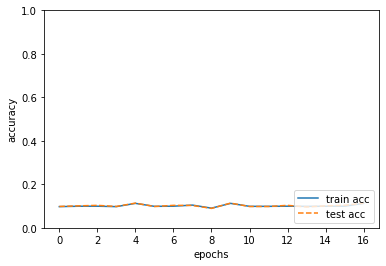

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 10   # ★ここを変えている。

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

精度もあがらず、しかもふらふらしている。

## 学習率を小さくしすぎた場合。（lr=1e-10)  
p.108下の例

train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135


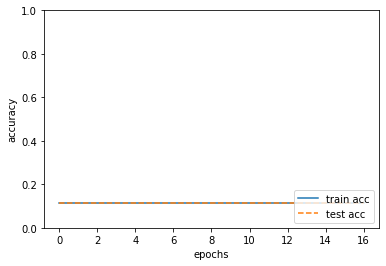

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 1e-10    # ★ここを変えている。

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 精度がまったくあがっていかない。

## では、lr=1.0にしてみたら？

train acc, test acc | 0.10218333333333333, 0.101
train acc, test acc | 0.9245833333333333, 0.9242
train acc, test acc | 0.9486666666666667, 0.9481
train acc, test acc | 0.9589, 0.9534
train acc, test acc | 0.9648666666666667, 0.9581
train acc, test acc | 0.9709666666666666, 0.963
train acc, test acc | 0.9742, 0.9662
train acc, test acc | 0.9766833333333333, 0.9671
train acc, test acc | 0.9788166666666667, 0.969
train acc, test acc | 0.9801333333333333, 0.9688
train acc, test acc | 0.9820666666666666, 0.9707
train acc, test acc | 0.9833333333333333, 0.9691
train acc, test acc | 0.985, 0.9718
train acc, test acc | 0.98575, 0.9702
train acc, test acc | 0.98605, 0.9719
train acc, test acc | 0.98815, 0.9728
train acc, test acc | 0.9888833333333333, 0.9726


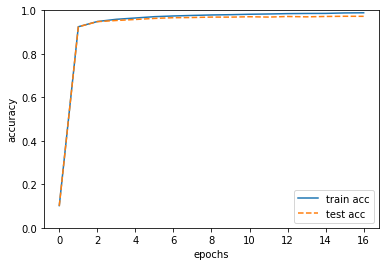

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 1    # ★ここを変えている。

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

lr=0.1より精度は高くなっている。ただし、テストデータについては1.5%ほど学習データより精度が低い。